In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/KLTN/dataset/yolo_v11_new/Detect Real Cars.v9-car_dataset_600_ver2.yolov11.zip" -d "/content/drive/MyDrive/KLTN/dataset/yolo_v11_new"

Archive:  /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/Detect Real Cars.v9-car_dataset_600_ver2.yolov11.zip
  inflating: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/README.dataset.txt  
  inflating: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/README.roboflow.txt  
  inflating: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/data.yaml  
   creating: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/test/
   creating: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/test/images/
 extracting: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/test/images/10219_png.rf.c202865888b969bc6930406f946a1005.jpg  
 extracting: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/test/images/102578_png.rf.c1c0d1d0d622707930cdebb66e4e90a9.jpg  
 extracting: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/test/images/1026000_png.rf.d020832e4b7f246f8b2488e3f185b7d4.jpg  
 extracting: /content/drive/MyDrive/KLTN/dataset/yolo_v11_new/test/images/10260070018_png.rf.4700a6d568b4149eb0a48d6c457bd1

In [ ]:
!pip install torch torchvision pycocotools tqdm

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:

class ParkingDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))])
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        label_path = os.path.join(self.labels_dir, self.images[idx].replace(".jpg", ".txt").replace(".png", ".txt"))

        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    line = line.strip()
                    if not line:
                        continue

                    parts = line.split()
                    if len(parts) != 5:
                        continue

                    try:
                        cls, x, y, w, h = map(float, parts)
                    except ValueError:
                        continue

                    # Convert YOLO to xyxy
                    x1 = max(0, (x - w/2) * width)
                    y1 = max(0, (y - h/2) * height)
                    x2 = min(width, (x + w/2) * width)
                    y2 = min(height, (y + h/2) * height)

                    if x2 > x1 and y2 > y1:
                        boxes.append([x1, y1, x2, y2])
                        labels.append(int(cls) + 1)  # 0 → 1 (car)

        # Handle empty annotations
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)
        else:
            img = torchvision.transforms.functional.to_tensor(img)

        return img, target

    def __len__(self):
        return len(self.images)


def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def collate_fn(batch):
    return tuple(zip(*batch))


# ============
# MODEL SETUP
# ============
def create_model_with_pretrained():
    """
    Create Faster R-CNN with COCO pre-trained weights
    This is the KEY CHANGE for fair comparison!
    """
    print("="*70)
    print("CREATING FASTER R-CNN WITH TRANSFER LEARNING")
    print("="*70)

    # Load model with DEFAULT (COCO) pre-trained weights
    # This is different from weights=None
    model = fasterrcnn_resnet50_fpn(weights='DEFAULT')

    print("Loaded COCO pre-trained weights:")
    print("   • Backbone: ResNet-50 trained on COCO")
    print("   • FPN: Pre-trained Feature Pyramid Network")
    print("   • RPN: Pre-trained Region Proposal Network")
    print("   • ROI Heads: Pre-trained (will be fine-tuned)")

    # Replace the box predictor for our custom number of classes
    # We only have 2 classes: background (0) + car (1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

    print("\nModified classification head:")
    print("   • Old: 91 classes (COCO)")
    print("   • New: 2 classes (background + car)")
    print("   • Only classification head is re-initialized")
    print("   • All other layers keep pre-trained weights")
    print("="*70 + "\n")

    return model

In [ ]:
class Config:
    # Paths
    train_images_dir = "/content/drive/MyDrive/KLTN/dataset/yolo_v11_new/train/images"
    train_labels_dir = "/content/drive/MyDrive/KLTN/dataset/yolo_v11_new/train/labels"
    val_images_dir = "/content/drive/MyDrive/KLTN/dataset/yolo_v11_new/valid/images"
    val_labels_dir = "/content/drive/MyDrive/KLTN/dataset/yolo_v11_new/valid/labels"

    # Training settings
    num_epochs = 30
    batch_size = 2
    learning_rate = 0.005  # Can be higher with pre-training

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Save paths
    output_dir = "faster_rcnn_pretrained"

config = Config()
os.makedirs(config.output_dir, exist_ok=True)

In [ ]:
# =============================
# LOAD DATASETS
# =============================
print("="*70)
print("LOADING DATASETS")
print("="*70)

train_dataset = ParkingDataset(
    config.train_images_dir,
    config.train_labels_dir,
    transforms=get_transform(train=True)
)

val_dataset = ParkingDataset(
    config.val_images_dir,
    config.val_labels_dir,
    transforms=get_transform(train=False)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print("="*70 + "\n")

LOADING DATASETS
Training samples: 1386
Validation samples: 70



CREATING FASTER R-CNN WITH TRANSFER LEARNING
Loaded COCO pre-trained weights:
   • Backbone: ResNet-50 trained on COCO
   • FPN: Pre-trained Feature Pyramid Network
   • RPN: Pre-trained Region Proposal Network
   • ROI Heads: Pre-trained (will be fine-tuned)

Modified classification head:
   • Old: 91 classes (COCO)
   • New: 2 classes (background + car)
   • Only classification head is re-initialized
   • All other layers keep pre-trained weights

STARTING TRAINING - FASTER R-CNN WITH TRANSFER LEARNING
Device: cuda
Epochs: 30
Batch size: 2
Learning rate: 0.005
Pre-trained: COCO weights



Epoch 1/30: 100%|██████████| 693/693 [02:54<00:00,  3.97it/s, loss=1.6551, lr=0.005000]



EPOCH 1/30 SUMMARY
Train Loss: 1.5898
   Classifier: 0.4155
   Box Reg: 0.4351
   Objectness: 0.5284
   RPN Box Reg: 0.2109
Val Loss: 0.5936
   Classifier: 0.1910
   Box Reg: 0.3013
   Objectness: 0.0604
   RPN Box Reg: 0.0408
Learning Rate: 0.005000
Saved best model! (val_loss: 0.5936)
  Initial best val_loss: 0.5936


Epoch 2/30: 100%|██████████| 693/693 [02:47<00:00,  4.15it/s, loss=1.0920, lr=0.005000]



EPOCH 2/30 SUMMARY
Train Loss: 1.2662
   Classifier: 0.3839
   Box Reg: 0.4050
   Objectness: 0.3013
   RPN Box Reg: 0.1760
Val Loss: 0.4433
   Classifier: 0.1595
   Box Reg: 0.1956
   Objectness: 0.0498
   RPN Box Reg: 0.0383
Learning Rate: 0.005000
Saved best model! (val_loss: 0.4433)
  Val loss improved by 0.1503


Epoch 3/30: 100%|██████████| 693/693 [02:46<00:00,  4.15it/s, loss=0.7441, lr=0.005000]



EPOCH 3/30 SUMMARY
Train Loss: 1.2175
   Classifier: 0.3802
   Box Reg: 0.4084
   Objectness: 0.2617
   RPN Box Reg: 0.1672
Val Loss: 0.4527
   Classifier: 0.1454
   Box Reg: 0.2243
   Objectness: 0.0415
   RPN Box Reg: 0.0415
Learning Rate: 0.005000
Best val_loss: 0.4433 (epoch 2)
  No improvement. EarlyStopping: 1/7


Epoch 4/30: 100%|██████████| 693/693 [02:47<00:00,  4.14it/s, loss=1.2274, lr=0.005000]



EPOCH 4/30 SUMMARY
Train Loss: 1.1606
   Classifier: 0.3709
   Box Reg: 0.4031
   Objectness: 0.2296
   RPN Box Reg: 0.1570
Val Loss: 0.3552
   Classifier: 0.1374
   Box Reg: 0.1511
   Objectness: 0.0382
   RPN Box Reg: 0.0284
Learning Rate: 0.005000
Saved best model! (val_loss: 0.3552)
  Val loss improved by 0.0881


Epoch 5/30: 100%|██████████| 693/693 [02:47<00:00,  4.13it/s, loss=1.3173, lr=0.005000]



EPOCH 5/30 SUMMARY
Train Loss: 1.1493
   Classifier: 0.3769
   Box Reg: 0.4060
   Objectness: 0.2123
   RPN Box Reg: 0.1541
Val Loss: 0.3319
   Classifier: 0.1260
   Box Reg: 0.1376
   Objectness: 0.0373
   RPN Box Reg: 0.0310
Learning Rate: 0.005000
Saved best model! (val_loss: 0.3319)
Checkpoint saved at epoch 5
  Val loss improved by 0.0233


Epoch 6/30: 100%|██████████| 693/693 [02:48<00:00,  4.11it/s, loss=1.5739, lr=0.005000]



EPOCH 6/30 SUMMARY
Train Loss: 1.1137
   Classifier: 0.3651
   Box Reg: 0.4070
   Objectness: 0.1934
   RPN Box Reg: 0.1483
Val Loss: 0.3146
   Classifier: 0.1094
   Box Reg: 0.1420
   Objectness: 0.0354
   RPN Box Reg: 0.0278
Learning Rate: 0.005000
Saved best model! (val_loss: 0.3146)
  Val loss improved by 0.0173


Epoch 7/30: 100%|██████████| 693/693 [02:47<00:00,  4.15it/s, loss=1.0394, lr=0.005000]



EPOCH 7/30 SUMMARY
Train Loss: 1.1082
   Classifier: 0.3688
   Box Reg: 0.4107
   Objectness: 0.1842
   RPN Box Reg: 0.1445
Val Loss: 0.3169
   Classifier: 0.1086
   Box Reg: 0.1516
   Objectness: 0.0254
   RPN Box Reg: 0.0313
Learning Rate: 0.005000
Best val_loss: 0.3146 (epoch 6)
  No improvement. EarlyStopping: 1/7


Epoch 8/30: 100%|██████████| 693/693 [02:47<00:00,  4.14it/s, loss=0.6333, lr=0.005000]



EPOCH 8/30 SUMMARY
Train Loss: 1.0902
   Classifier: 0.3638
   Box Reg: 0.4121
   Objectness: 0.1729
   RPN Box Reg: 0.1414
Val Loss: 0.2885
   Classifier: 0.1115
   Box Reg: 0.1253
   Objectness: 0.0268
   RPN Box Reg: 0.0249
Learning Rate: 0.005000
Saved best model! (val_loss: 0.2885)
  Val loss improved by 0.0261


Epoch 9/30: 100%|██████████| 693/693 [02:47<00:00,  4.14it/s, loss=1.6816, lr=0.005000]



EPOCH 9/30 SUMMARY
Train Loss: 1.0585
   Classifier: 0.3559
   Box Reg: 0.4065
   Objectness: 0.1580
   RPN Box Reg: 0.1382
Val Loss: 0.2953
   Classifier: 0.1042
   Box Reg: 0.1291
   Objectness: 0.0360
   RPN Box Reg: 0.0261
Learning Rate: 0.005000
Best val_loss: 0.2885 (epoch 8)
  No improvement. EarlyStopping: 1/7


Epoch 10/30: 100%|██████████| 693/693 [02:49<00:00,  4.10it/s, loss=1.1480, lr=0.005000]



EPOCH 10/30 SUMMARY
Train Loss: 1.0650
   Classifier: 0.3600
   Box Reg: 0.4128
   Objectness: 0.1551
   RPN Box Reg: 0.1371
Val Loss: 0.2733
   Classifier: 0.0936
   Box Reg: 0.1245
   Objectness: 0.0301
   RPN Box Reg: 0.0252
Learning Rate: 0.005000
Saved best model! (val_loss: 0.2733)
Checkpoint saved at epoch 10
  Val loss improved by 0.0152


Epoch 11/30: 100%|██████████| 693/693 [02:49<00:00,  4.10it/s, loss=0.7868, lr=0.005000]



EPOCH 11/30 SUMMARY
Train Loss: 1.0435
   Classifier: 0.3539
   Box Reg: 0.4042
   Objectness: 0.1508
   RPN Box Reg: 0.1346
Val Loss: 0.3060
   Classifier: 0.0983
   Box Reg: 0.1554
   Objectness: 0.0243
   RPN Box Reg: 0.0280
Learning Rate: 0.005000
Best val_loss: 0.2733 (epoch 10)
  No improvement. EarlyStopping: 1/7


Epoch 12/30: 100%|██████████| 693/693 [02:48<00:00,  4.11it/s, loss=0.8696, lr=0.005000]



EPOCH 12/30 SUMMARY
Train Loss: 1.0535
   Classifier: 0.3618
   Box Reg: 0.4147
   Objectness: 0.1423
   RPN Box Reg: 0.1347
Val Loss: 0.2701
   Classifier: 0.0928
   Box Reg: 0.1175
   Objectness: 0.0358
   RPN Box Reg: 0.0239
Learning Rate: 0.005000
Saved best model! (val_loss: 0.2701)
  Val loss improved by 0.0032


Epoch 13/30: 100%|██████████| 693/693 [02:48<00:00,  4.10it/s, loss=0.7742, lr=0.005000]



EPOCH 13/30 SUMMARY
Train Loss: 1.0493
   Classifier: 0.3612
   Box Reg: 0.4131
   Objectness: 0.1415
   RPN Box Reg: 0.1335
Val Loss: 0.2539
   Classifier: 0.0874
   Box Reg: 0.1205
   Objectness: 0.0201
   RPN Box Reg: 0.0260
Learning Rate: 0.005000
Saved best model! (val_loss: 0.2539)
  Val loss improved by 0.0162


Epoch 14/30: 100%|██████████| 693/693 [02:48<00:00,  4.11it/s, loss=1.9060, lr=0.005000]



EPOCH 14/30 SUMMARY
Train Loss: 1.0265
   Classifier: 0.3525
   Box Reg: 0.4103
   Objectness: 0.1335
   RPN Box Reg: 0.1303
Val Loss: 0.2494
   Classifier: 0.0859
   Box Reg: 0.1176
   Objectness: 0.0209
   RPN Box Reg: 0.0249
Learning Rate: 0.005000
Saved best model! (val_loss: 0.2494)
  Val loss improved by 0.0045


Epoch 15/30: 100%|██████████| 693/693 [02:49<00:00,  4.09it/s, loss=1.3441, lr=0.005000]



EPOCH 15/30 SUMMARY
Train Loss: 1.0263
   Classifier: 0.3529
   Box Reg: 0.4119
   Objectness: 0.1315
   RPN Box Reg: 0.1300
Val Loss: 0.2425
   Classifier: 0.0826
   Box Reg: 0.1084
   Objectness: 0.0285
   RPN Box Reg: 0.0231
Learning Rate: 0.005000
Saved best model! (val_loss: 0.2425)
Checkpoint saved at epoch 15
  Val loss improved by 0.0069


Epoch 16/30: 100%|██████████| 693/693 [02:48<00:00,  4.11it/s, loss=0.9516, lr=0.005000]



EPOCH 16/30 SUMMARY
Train Loss: 1.0258
   Classifier: 0.3536
   Box Reg: 0.4142
   Objectness: 0.1282
   RPN Box Reg: 0.1299
Val Loss: 0.2785
   Classifier: 0.0982
   Box Reg: 0.1145
   Objectness: 0.0401
   RPN Box Reg: 0.0256
Learning Rate: 0.000500
Best val_loss: 0.2425 (epoch 15)
  No improvement. EarlyStopping: 1/7


Epoch 17/30: 100%|██████████| 693/693 [02:47<00:00,  4.13it/s, loss=0.7545, lr=0.000500]



EPOCH 17/30 SUMMARY
Train Loss: 0.9703
   Classifier: 0.3415
   Box Reg: 0.4026
   Objectness: 0.1062
   RPN Box Reg: 0.1200
Val Loss: 0.2320
   Classifier: 0.0829
   Box Reg: 0.1025
   Objectness: 0.0261
   RPN Box Reg: 0.0205
Learning Rate: 0.000500
Saved best model! (val_loss: 0.2320)
  Val loss improved by 0.0105


Epoch 18/30: 100%|██████████| 693/693 [02:49<00:00,  4.09it/s, loss=0.6318, lr=0.000500]



EPOCH 18/30 SUMMARY
Train Loss: 0.9562
   Classifier: 0.3353
   Box Reg: 0.4023
   Objectness: 0.1006
   RPN Box Reg: 0.1180
Val Loss: 0.2343
   Classifier: 0.0851
   Box Reg: 0.0990
   Objectness: 0.0287
   RPN Box Reg: 0.0214
Learning Rate: 0.000500
Best val_loss: 0.2320 (epoch 17)
  No improvement. EarlyStopping: 1/7


Epoch 19/30: 100%|██████████| 693/693 [02:48<00:00,  4.12it/s, loss=1.2513, lr=0.000500]



EPOCH 19/30 SUMMARY
Train Loss: 0.9386
   Classifier: 0.3307
   Box Reg: 0.3957
   Objectness: 0.0947
   RPN Box Reg: 0.1175
Val Loss: 0.2334
   Classifier: 0.0827
   Box Reg: 0.1024
   Objectness: 0.0273
   RPN Box Reg: 0.0211
Learning Rate: 0.000500
Best val_loss: 0.2320 (epoch 17)
  No improvement. EarlyStopping: 2/7


Epoch 20/30: 100%|██████████| 693/693 [02:48<00:00,  4.12it/s, loss=1.2158, lr=0.000500]



EPOCH 20/30 SUMMARY
Train Loss: 0.9550
   Classifier: 0.3369
   Box Reg: 0.4029
   Objectness: 0.0968
   RPN Box Reg: 0.1183
Val Loss: 0.2332
   Classifier: 0.0823
   Box Reg: 0.0999
   Objectness: 0.0293
   RPN Box Reg: 0.0217
Learning Rate: 0.000500
Best val_loss: 0.2320 (epoch 17)
Checkpoint saved at epoch 20
  No improvement. EarlyStopping: 3/7


Epoch 21/30: 100%|██████████| 693/693 [02:50<00:00,  4.07it/s, loss=1.1672, lr=0.000500]



EPOCH 21/30 SUMMARY
Train Loss: 0.9683
   Classifier: 0.3430
   Box Reg: 0.4101
   Objectness: 0.0963
   RPN Box Reg: 0.1190
Val Loss: 0.2298
   Classifier: 0.0840
   Box Reg: 0.0984
   Objectness: 0.0269
   RPN Box Reg: 0.0206
Learning Rate: 0.000500
Saved best model! (val_loss: 0.2298)
  Val loss improved by 0.0022


Epoch 22/30: 100%|██████████| 693/693 [02:48<00:00,  4.10it/s, loss=1.0324, lr=0.000500]



EPOCH 22/30 SUMMARY
Train Loss: 0.9492
   Classifier: 0.3345
   Box Reg: 0.4021
   Objectness: 0.0947
   RPN Box Reg: 0.1179
Val Loss: 0.2384
   Classifier: 0.0862
   Box Reg: 0.1007
   Objectness: 0.0302
   RPN Box Reg: 0.0213
Learning Rate: 0.000050
Best val_loss: 0.2298 (epoch 21)
  No improvement. EarlyStopping: 1/7


Epoch 23/30: 100%|██████████| 693/693 [02:48<00:00,  4.12it/s, loss=1.7574, lr=0.000050]



EPOCH 23/30 SUMMARY
Train Loss: 0.9361
   Classifier: 0.3311
   Box Reg: 0.3981
   Objectness: 0.0915
   RPN Box Reg: 0.1156
Val Loss: 0.2290
   Classifier: 0.0821
   Box Reg: 0.0972
   Objectness: 0.0291
   RPN Box Reg: 0.0206
Learning Rate: 0.000050
Saved best model! (val_loss: 0.2290)
  No improvement. EarlyStopping: 2/7


Epoch 24/30: 100%|██████████| 693/693 [02:48<00:00,  4.10it/s, loss=0.4767, lr=0.000050]



EPOCH 24/30 SUMMARY
Train Loss: 0.9465
   Classifier: 0.3365
   Box Reg: 0.4005
   Objectness: 0.0935
   RPN Box Reg: 0.1161
Val Loss: 0.2270
   Classifier: 0.0787
   Box Reg: 0.0981
   Objectness: 0.0296
   RPN Box Reg: 0.0207
Learning Rate: 0.000050
Saved best model! (val_loss: 0.2270)
  Val loss improved by 0.0028


Epoch 25/30: 100%|██████████| 693/693 [02:48<00:00,  4.11it/s, loss=1.2508, lr=0.000050]



EPOCH 25/30 SUMMARY
Train Loss: 0.9369
   Classifier: 0.3321
   Box Reg: 0.3983
   Objectness: 0.0907
   RPN Box Reg: 0.1158
Val Loss: 0.2285
   Classifier: 0.0799
   Box Reg: 0.0983
   Objectness: 0.0293
   RPN Box Reg: 0.0209
Learning Rate: 0.000050
Best val_loss: 0.2270 (epoch 24)
Checkpoint saved at epoch 25
  No improvement. EarlyStopping: 1/7


Epoch 26/30: 100%|██████████| 693/693 [02:48<00:00,  4.12it/s, loss=1.1969, lr=0.000050]



EPOCH 26/30 SUMMARY
Train Loss: 0.9530
   Classifier: 0.3375
   Box Reg: 0.4063
   Objectness: 0.0925
   RPN Box Reg: 0.1166
Val Loss: 0.2340
   Classifier: 0.0822
   Box Reg: 0.1008
   Objectness: 0.0300
   RPN Box Reg: 0.0209
Learning Rate: 0.000050
Best val_loss: 0.2270 (epoch 24)
  No improvement. EarlyStopping: 2/7


Epoch 27/30: 100%|██████████| 693/693 [02:48<00:00,  4.12it/s, loss=0.5702, lr=0.000050]



EPOCH 27/30 SUMMARY
Train Loss: 0.9344
   Classifier: 0.3306
   Box Reg: 0.3984
   Objectness: 0.0898
   RPN Box Reg: 0.1156
Val Loss: 0.2296
   Classifier: 0.0805
   Box Reg: 0.0974
   Objectness: 0.0309
   RPN Box Reg: 0.0208
Learning Rate: 0.000050
Best val_loss: 0.2270 (epoch 24)
  No improvement. EarlyStopping: 3/7


Epoch 28/30: 100%|██████████| 693/693 [02:48<00:00,  4.12it/s, loss=0.8807, lr=0.000050]



EPOCH 28/30 SUMMARY
Train Loss: 0.9312
   Classifier: 0.3288
   Box Reg: 0.3969
   Objectness: 0.0902
   RPN Box Reg: 0.1153
Val Loss: 0.2251
   Classifier: 0.0793
   Box Reg: 0.0982
   Objectness: 0.0274
   RPN Box Reg: 0.0202
Learning Rate: 0.000050
Saved best model! (val_loss: 0.2251)
  Val loss improved by 0.0019


Epoch 29/30: 100%|██████████| 693/693 [02:48<00:00,  4.12it/s, loss=0.9272, lr=0.000050]



EPOCH 29/30 SUMMARY
Train Loss: 0.9213
   Classifier: 0.3257
   Box Reg: 0.3925
   Objectness: 0.0878
   RPN Box Reg: 0.1153
Val Loss: 0.2311
   Classifier: 0.0813
   Box Reg: 0.0999
   Objectness: 0.0296
   RPN Box Reg: 0.0203
Learning Rate: 0.000050
Best val_loss: 0.2251 (epoch 28)
  No improvement. EarlyStopping: 1/7


Epoch 30/30: 100%|██████████| 693/693 [02:48<00:00,  4.12it/s, loss=0.7880, lr=0.000050]



EPOCH 30/30 SUMMARY
Train Loss: 0.9405
   Classifier: 0.3324
   Box Reg: 0.3996
   Objectness: 0.0918
   RPN Box Reg: 0.1166
Val Loss: 0.2266
   Classifier: 0.0785
   Box Reg: 0.0981
   Objectness: 0.0288
   RPN Box Reg: 0.0212
Learning Rate: 0.000050
Best val_loss: 0.2251 (epoch 28)
Checkpoint saved at epoch 30
  No improvement. EarlyStopping: 2/7

TRAINING COMPLETED - FASTER R-CNN WITH TRANSFER LEARNING
Total Epochs: 30
Best Epoch: 28
Best Val Loss: 0.2251
Model saved: faster_rcnn_pretrained/best_faster_rcnn_pretrained.pth
Pre-trained: ✅ COCO weights

Training curves saved to: faster_rcnn_pretrained/training_curves.png


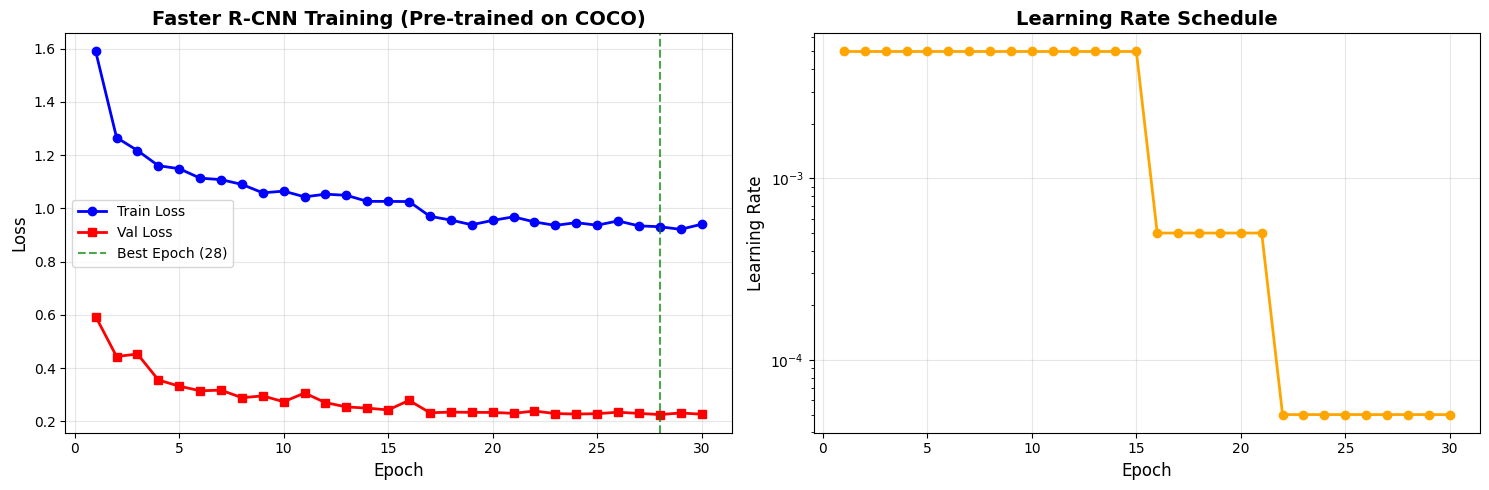

In [ ]:
# =============================
# CREATE MODEL
# =============================
model = create_model_with_pretrained()
model = model.to(config.device)


# =============================
# OPTIMIZER & SCHEDULER
# =============================
# Fine-tuning strategy: Lower learning rate for pre-trained layers
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=config.learning_rate,
    momentum=0.9,
    weight_decay=0.0005
)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[16, 22],
    gamma=0.1
)

# Warmup
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

warmup_scheduler = warmup_lr_scheduler(optimizer, warmup_iters=500, warmup_factor=1./3)


# =============================
# EARLY STOPPING
# =============================
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
            if self.verbose:
                print(f"  Initial best val_loss: {val_loss:.4f}")
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"  No improvement. EarlyStopping: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"  Early stopping triggered! Best was epoch {self.best_epoch+1}")
        else:
            if self.verbose:
                improvement = self.best_loss - val_loss
                print(f"  Val loss improved by {improvement:.4f}")
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0

        return self.early_stop


# =============================
# VALIDATION FUNCTION
# =============================
@torch.no_grad()
def validate(model, val_loader, device):
    model.train()  # Keep in training mode to get losses
    val_loss = 0
    loss_components = {
        'loss_classifier': 0,
        'loss_box_reg': 0,
        'loss_objectness': 0,
        'loss_rpn_box_reg': 0
    }
    num_batches = 0

    for imgs, targets in val_loader:
        imgs = list(i.to(device) for i in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        val_loss += losses.item()

        for key, value in loss_dict.items():
            if key in loss_components:
                loss_components[key] += value.item()

        num_batches += 1

    avg_val_loss = val_loss / num_batches if num_batches > 0 else 0

    for key in loss_components:
        loss_components[key] /= num_batches if num_batches > 0 else 1

    return avg_val_loss, loss_components


# =============================
# TRAINING LOOP
# =============================
print("="*70)
print("STARTING TRAINING - FASTER R-CNN WITH TRANSFER LEARNING")
print("="*70)
print(f"Device: {config.device}")
print(f"Epochs: {config.num_epochs}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {config.learning_rate}")
print(f"Pre-trained: COCO weights")
print("="*70 + "\n")

best_val_loss = float('inf')
best_epoch = 0
train_losses = []
val_losses = []
learning_rates = []

early_stopping = EarlyStopping(patience=7, verbose=True)

# Mixed precision
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None
use_amp = torch.cuda.is_available()

iteration = 0

for epoch in range(config.num_epochs):
    model.train()
    epoch_loss = 0
    epoch_loss_components = {
        'loss_classifier': 0,
        'loss_box_reg': 0,
        'loss_objectness': 0,
        'loss_rpn_box_reg': 0
    }
    num_batches = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')

    for batch_idx, (imgs, targets) in enumerate(progress_bar):
        imgs = list(i.to(config.device) for i in imgs)
        targets = [{k: v.to(config.device) for k, v in t.items()} for t in targets]

        if use_amp:
            with torch.amp.autocast('cuda'):
                loss_dict = model(imgs, targets)
                losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            scaler.scale(losses).backward()

            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            if iteration < 500:
                warmup_scheduler.step()

            iteration += 1
        else:
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if iteration < 500:
                warmup_scheduler.step()

            iteration += 1

        epoch_loss += losses.item()
        for key, value in loss_dict.items():
            if key in epoch_loss_components:
                epoch_loss_components[key] += value.item()
        num_batches += 1

        current_lr = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix({
            'loss': f'{losses.item():.4f}',
            'lr': f'{current_lr:.6f}'
        })

    avg_train_loss = epoch_loss / num_batches
    train_losses.append(avg_train_loss)

    for key in epoch_loss_components:
        epoch_loss_components[key] /= num_batches

    # Validation
    val_loss, val_loss_components = validate(model, val_loader, config.device)
    val_losses.append(val_loss)

    # Update LR
    if iteration >= 500:
        lr_scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Print summary
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch+1}/{config.num_epochs} SUMMARY")
    print(f"{'='*70}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"   Classifier: {epoch_loss_components['loss_classifier']:.4f}")
    print(f"   Box Reg: {epoch_loss_components['loss_box_reg']:.4f}")
    print(f"   Objectness: {epoch_loss_components['loss_objectness']:.4f}")
    print(f"   RPN Box Reg: {epoch_loss_components['loss_rpn_box_reg']:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"   Classifier: {val_loss_components['loss_classifier']:.4f}")
    print(f"   Box Reg: {val_loss_components['loss_box_reg']:.4f}")
    print(f"   Objectness: {val_loss_components['loss_objectness']:.4f}")
    print(f"   RPN Box Reg: {val_loss_components['loss_rpn_box_reg']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss,
            'pretrained': True,  # Mark as pre-trained model
        }, os.path.join(config.output_dir, 'best_faster_rcnn_pretrained.pth'))
        print(f"Saved best model! (val_loss: {val_loss:.4f})")
    else:
        print(f"Best val_loss: {best_val_loss:.4f} (epoch {best_epoch+1})")

    # Checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, os.path.join(config.output_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved at epoch {epoch+1}")

    # Early stopping
    if early_stopping(val_loss, epoch):
        print(f"\n{'='*70}")
        print("TRAINING STOPPED EARLY")
        print(f"{'='*70}")
        print(f"Final Epoch: {epoch+1}/{config.num_epochs}")
        print(f"Best Epoch: {best_epoch+1}")
        print(f"Best Val Loss: {best_val_loss:.4f}")
        print(f"{'='*70}\n")
        break

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'final_epoch': epoch,
    'best_epoch': best_epoch,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'pretrained': True,
}, os.path.join(config.output_dir, "faster_rcnn_pretrained_final.pth"))

print("\n" + "="*70)
print("TRAINING COMPLETED - FASTER R-CNN WITH TRANSFER LEARNING")
print("="*70)
print(f"Total Epochs: {len(train_losses)}")
print(f"Best Epoch: {best_epoch+1}")
print(f"Best Val Loss: {best_val_loss:.4f}")
print(f"Model saved: {config.output_dir}/best_faster_rcnn_pretrained.pth")
print(f"Pre-trained: ✅ COCO weights")
print("="*70 + "\n")


# =============================
# VISUALIZATION
# =============================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1 = axes[0]
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o')
ax1.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2, marker='s')
ax1.axvline(x=best_epoch+1, color='g', linestyle='--',
            label=f'Best Epoch ({best_epoch+1})', alpha=0.7)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Faster R-CNN Training (Pre-trained on COCO)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Learning rate
ax2 = axes[1]
ax2.plot(epochs_range, learning_rates, 'orange', linewidth=2, marker='o')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, 'training_curves.png'), dpi=300)
print(f"Training curves saved to: {config.output_dir}/training_curves.png")
plt.show()

In [ ]:
import shutil
import os

source_folder = '/content/faster_rcnn_pretrained/best_faster_rcnn_pretrained.pth'
destination_folder = '/content/drive/MyDrive/KLTN/best_faster_rcnn_pretrained.pth'

try:
    # Check if the destination folder already exists
    if os.path.exists(destination_folder):
        print(f"Destination folder '{destination_folder}' already exists. Deleting it to ensure a clean copy.")
        shutil.rmtree(destination_folder)

    shutil.copytree(source_folder, destination_folder)
    print(f"Successfully copied '{source_folder}' to '{destination_folder}'")
except FileNotFoundError:
    print(f"Error: Source folder '{source_folder}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: [Errno 20] Not a directory: '/content/faster_rcnn_pretrained/best_faster_rcnn_pretrained.pth'
